In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
from cartopy.util import add_cyclic_point
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


In [2]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [4]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_h1(ds):
       
    keepVars = ['LHFLX','SHFLX','PRECC','PRECT','PRECZ','TREFHT','QREFHT',
                'U10','UGUST', 
                'OMEGA500','U200','V200','U850','V850']
        
    ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex() 
    dsSel      = ds[keepVars]

    
    return dsSel



## Read in gust/ctrl CAM data (daily)

In [5]:
testDir     = '/glade/scratch/mdfowler/archive/'

case_IDs  = [
               'FLT2000_ctrl',
               'FLT2000_gust',    
               # 'FLT2000_gust_x2',    
    
                'FLTHIST_ctrl',
                'FLTHIST_gust',
              ]

caseNames = [
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsOFF.003',
            'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsON.003',
            # 'FLT2000_prelim.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsON_ugustX2.003',
    
            'FLTHIST_v0c.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsOFF.001',
            'FLTHIST_v0c.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112_fullOutput_gustsON.001',
]

for iCase in range(len(case_IDs)):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Get list of files 
    listFiles_h1 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h1.????-*'))
    
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h1 files loaded')
    
    ## Add case ID (short name) to the DS
    case_h1      = case_h1.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
    ## Info on dates available
    print('Min year (h1): ', np.nanmin(case_h1['time.year'].values))
    print('Max year (h1): ', np.nanmax(case_h1['time.year'].values))
    
    ## Return all the cases in a single dataset
    if iCase==0:
        all_h1 = case_h1
        del case_h1
    else: 
        all_h1 = xr.concat([all_h1, case_h1], "case") 
        del case_h1
    

*** Starting on case FLT2000_ctrl ***


KeyboardInterrupt: 

In [ ]:
## Read in ocnMask once: 
listFiles_h0 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h0.????-*'))

camDS = xr.open_dataset(listFiles_h0[0], decode_times=True)
ocnMask_cam = camDS.OCNFRAC.values
ocnMask_cam[np.where(ocnMask_cam!=1)] = np.nan


## What about some scatter plots of daily data?

The next 4 cells are meant to take hourly EAR5 data and average those up to the daily level

In [320]:
# ## Makey daily means, not hourly 
# # file_hr = '/Users/mdfowler/Downloads/ERA5_hourly_slhf_2013.nc'
# # file_hr = '/Users/mdfowler/Downloads/ERA5_hourly_tp_2013.nc'
# # file_hr = '/Users/mdfowler/Downloads/ERA5_hourly_u10n_2013.nc'
# file_hr = '/Users/mdfowler/Downloads/ERA5_hourly_v10n_2013.nc'

# hrDS = xr.open_dataset(file_hr, decode_times=True)

# dailyDS = hrDS.resample(time='1D').mean()



In [10]:
# dailyDS

In [322]:
# # saveName = '/Users/mdfowler/Downloads/ERA5_daily_slhf_2013.nc'
# # saveName = '/Users/mdfowler/Downloads/ERA5_daily_tp_2013.nc'
# # saveName = '/Users/mdfowler/Downloads/ERA5_daily_u10n_2013.nc'
# saveName = '/Users/mdfowler/Downloads/ERA5_daily_v10n_2013.nc'

# dailyDS.to_netcdf(saveName, 'w')


In [323]:
# del hrDS,dailyDS

Read in the daily data for the first year of interest (2014)

In [7]:
## Read in all the daily data, and put it in a single ERA5 DS 
baseDir = '/glade/work/mdfowler/obs/'
fileNames = [baseDir+'ERA5_daily_slhf.nc', 
             baseDir+'ERA5_daily_tp.nc', 
             baseDir+'ERA5_daily_u10n.nc',
             baseDir+'ERA5_daily_v10n.nc']

for iFile in range(len(fileNames)):
    ds = xr.open_dataset(fileNames[iFile], decode_times=True)

    if iFile==0: 
        era5_daily = ds 
    else: 
        era5_daily = xr.merge([era5_daily, ds])
        
## Read in land/sea mask 
fileName = baseDir+'ERA5_LandSeaMask.nc'
maskDS   = xr.open_dataset(fileName, decode_times=True)

ocnMask  = np.full([len(maskDS.latitude.values), len(maskDS.longitude.values)], np.nan)
ocnMask[maskDS.isel(time=0).lsm.values==0] = 1

Might want a few more year, so read those in too

In [8]:
## Can we add extra years? 
yrString = ['_2013']

for iYr in range(len(yrString)):
    fileNames = [baseDir+'ERA5_daily_slhf'+yrString[iYr]+'.nc', 
                 baseDir+'ERA5_daily_tp'+yrString[iYr]+'.nc', 
                 baseDir+'ERA5_daily_u10n'+yrString[iYr]+'.nc',
                 baseDir+'ERA5_daily_v10n'+yrString[iYr]+'.nc']

    for iFile in range(len(fileNames)):
        ds = xr.open_dataset(fileNames[iFile], decode_times=True)

        if iFile==0: 
            era5_dailyYear = ds 
        else: 
            era5_dailyYear = xr.merge([era5_dailyYear, ds])

    era5_daily = xr.concat([era5_daily, era5_dailyYear], dim='time').sortby('time')

In [9]:
era5_daily.longitude

<xarray.DataArray 'longitude' (longitude: 1440)>
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    units:      degrees_east
    long_name:  longitude

In [10]:
## Regrid ERA5
camGrid = all_h1['LHFLX'].isel(time=0,case=0).load().squeeze()

era5_daily = era5_daily.reindex(latitude=era5_daily.latitude[::-1])
era5_daily = era5_daily.rename_dims(dims_dict={'latitude':'lat', 'longitude':'lon'})
era5_daily = era5_daily.rename(name_dict={'latitude':'lat', 'longitude':'lon'})

# lhflx_era5 = era5_obs['slhf'].where(era5_obs['slhf'].values>-999)
lhflx_era5 = -era5_daily['slhf']/3600.0   # Normalize by the accumulation period in seconds (this is based on hourly data that's been scaled up)
regridERA5_lhflx = regrid_data(lhflx_era5, camGrid, method=1)

## NOW: use neutral winds for 10m u and v 
era5_u10_temp = era5_daily['u10n']
era5_v10_temp = era5_daily['v10n']
u10_era5 = np.sqrt(era5_u10_temp**2 + era5_v10_temp**2)
regridERA5_u10 = regrid_data(u10_era5, camGrid, method=1)

era5_prect_temp  = era5_daily['tp']
era5_prect_temp  =  era5_prect_temp *1000.0*24   # 1e3 get from m to mm; then this is a mean per hour, and we want per day, so *24
regridERA5_prect = regrid_data(era5_prect_temp, camGrid, method=1)

## Combine back into one xarray dataset
regridERA5 = regridERA5_lhflx.to_dataset()
regridERA5['U10'] = (('time','lat','lon'), regridERA5_u10.values)
regridERA5['tp']  = (('time','lat','lon'), regridERA5_prect.values)


In [42]:
regridERA5

<xarray.Dataset>
Dimensions:  (time: 730, lon: 288, lat: 192)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2014-12-31
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Data variables:
    slhf     (time, lat, lon) float64 -0.1815 -0.1815 -0.1815 ... -1.291 -1.291
    U10      (time, lat, lon) float64 0.365 0.365 0.365 ... 0.1771 0.1771 0.1771
    tp       (time, lat, lon) float64 -8.941e-05 -8.941e-05 ... 8.941e-05

In [ ]:
# era5_daily

In [9]:
# ## convert some units! Should confirm that this is right for tp in particular, but it seems to be...
# era5_daily['slhf'] = -era5_daily['slhf']/3600.0   # Normalize by the accumulation period in seconds (this is based on hourly data that's been scaled up)
# era5_daily['tp']   = era5_daily['tp']*1000.0*24   # 1e3 get from m to mm; then this is a mean per hour, and we want per day, so *24


In [10]:
# era5_daily['U10n'] = np.sqrt(era5_daily['u10n']**2 + era5_daily['v10n']**2)

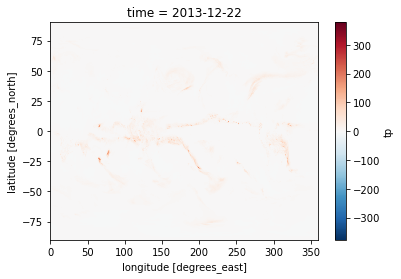

In [7]:
(era5_daily['tp'].isel(time=355)).plot()

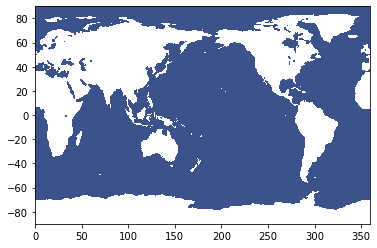

In [8]:
# Sanity check: land/sea mask 
plt.contourf(maskDS.longitude.values, maskDS.latitude.values, ocnMask*maskDS.isel(time=0).lsm.values)


## Scatters based on daily data?

In [25]:
## Select region/time 

iTimes_cam  = np.where( (all_h1['time.month']==12) | (all_h1['time.month']<=2) )[0]
iTimes_era5 = np.where( (regridERA5['time.month']==12) | (regridERA5['time.month']<=2) )[0]

all_h1_DJF     = all_h1.isel(time=iTimes_cam)
regridERA5_DJF = regridERA5.isel(time=iTimes_era5)

## Select the last two years of all_h1 as well, to be fully comparable? 
iYears_cam = np.where( (all_h1_DJF['time.year']>=2013) | (all_h1_DJF['time.year']==9) | (all_h1['time.year']==10) )[0]

## Equatorial Indian Ocean 
regName = 'Eq. IO' 
ilats   = np.where( (all_h1_DJF.lat.values>=-15) & (all_h1_DJF.lat.values<=15) )[0]
ilons   = np.where( (all_h1_DJF.lon.values>=40) & (all_h1_DJF.lon.values<=105) )[0]

sel_h1   = all_h1_DJF.isel(lat=ilats, lon=ilons, time = iYears_cam)
sel_h1_allYears   = all_h1_DJF.isel(lat=ilats, lon=ilons)
sel_era5 = regridERA5_DJF.isel(lat=ilats, lon=ilons)

reg_ocnMask = ocnMask_cam[0,ilats,:]
reg_ocnMask = reg_ocnMask[:,ilons]

reg_ocnMask_CAM  = np.full([len(sel_h1.time.values), len(sel_h1.lat.values), len(sel_h1.lon.values)], np.nan)
reg_ocnMask_ERA5 = np.full([len(sel_era5.time.values), len(sel_era5.lat.values), len(sel_era5.lon.values)], np.nan)

for iT in range(len(sel_h1.time.values)): 
    reg_ocnMask_CAM[iT,:,:] = reg_ocnMask
    
for iT in range(len(sel_era5.time.values)): 
    reg_ocnMask_ERA5[iT,:,:] = reg_ocnMask


In [26]:
numEl_CAM  = len(sel_h1.time.values)*len(sel_h1.lat.values)*len(sel_h1.lon.values)
numEl_ERA5 = len(sel_era5.time.values)*len(sel_era5.lat.values)*len(sel_era5.lon.values)

In [33]:
## Set any limits?

def set_RainLimit(DS, upperMax):
    rainLim = upperMax / (86400*1e3)  # convert limit from mm/d to m/s
    return DS.where(DS.PRECC>=rainLim), 'Rain>='+str(upperMax)+' mm/d'


In [34]:
sel_h1,rainLimString = set_RainLimit(sel_h1, 0.25)
sel_era5  = sel_era5.where(sel_era5.tp>=0.25)


In [120]:
int(np.round((yMax-yMin)/5))

40

Text(0.5, 1.0, 'Daily DJF FLTHIST_gust')

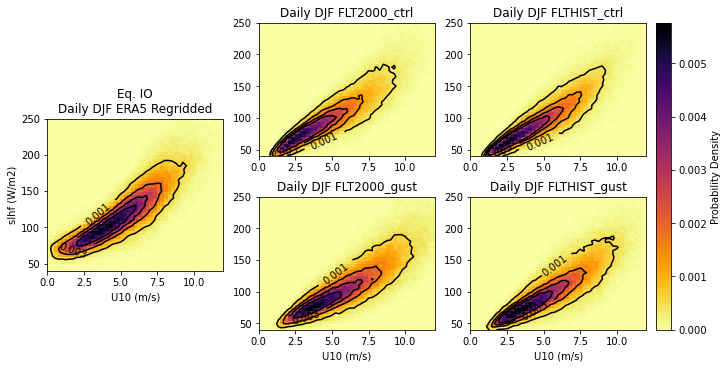

In [35]:
xVar = 'U10'
yVar = 'LHFLX'

xMult = 1
yMult = 1

xUnits = 'm/s'
yUnits = 'W/m2'

xVar_obs = 'U10'
yVar_obs = 'slhf'

xMin = 0
xMax = 12

yMin = 40
yMax = 250

nBins_X = int((xMax-xMin)/0.25)
nBins_Y = int(np.round((yMax-yMin)/5))

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## Shouldn't need to change anything here; but create 1d arrays 
obs_xVar = np.asarray(pd.DataFrame((sel_era5[xVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]
obs_yVar = np.asarray(pd.DataFrame((sel_era5[yVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]

cam0_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam0_yVar = np.asarray(pd.DataFrame((sel_h1[yVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam1_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam1_yVar = np.asarray(pd.DataFrame((sel_h1[yVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam3_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=2).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam3_yVar = np.asarray(pd.DataFrame((sel_h1[yVar].isel(case=2).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam4_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=3).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam4_yVar = np.asarray(pd.DataFrame((sel_h1[yVar].isel(case=3).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]


## Make the plot
fig3 = plt.figure(constrained_layout=True, figsize=(10,5))
gs   = fig3.add_gridspec(4,4, width_ratios=[1,1,1,0.09], height_ratios=[0.75,1,1,0.75])

axs0 = fig3.add_subplot(gs[1:3, 0])
cplt = axs0.hist2d(obs_xVar, obs_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs0.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0045,0.001), inline=True, colors='k')
axs0.clabel(CS, CS.levels[::2], inline=True)

axs1 = fig3.add_subplot(gs[0:2, 1])
cplt = axs1.hist2d(cam0_xVar, cam0_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs1.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0045,0.001), inline=True, colors='k')
axs1.clabel(CS, CS.levels[::2], inline=True)

axs2 = fig3.add_subplot(gs[0:2, 2])
cplt = axs2.hist2d(cam3_xVar, cam3_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs2.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0045,0.001), inline=True, colors='k')
axs2.clabel(CS, CS.levels[::2], inline=True)

axs3 = fig3.add_subplot(gs[2::, 1])
cplt = axs3.hist2d(cam1_xVar, cam1_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs3.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0045,0.001), inline=True, colors='k')
axs3.clabel(CS, CS.levels[::2], inline=True)

axs4 = fig3.add_subplot(gs[2::, 2])
cplt = axs4.hist2d(cam4_xVar, cam4_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs4.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0045,0.001),inline=True, colors='k')
axs4.clabel(CS, CS.levels[::2], inline=True)

axsC = fig3.add_subplot(gs[0::, 3])
plt.colorbar(cplt[3], cax=axsC, label='Probability Density')

## Plot options 
axs0.set_xlabel(xVar_obs+' ('+xUnits+')')
axs0.set_ylabel(yVar_obs+' ('+yUnits+')')

axs3.set_xlabel(xVar+' ('+xUnits+')')
axs4.set_xlabel(xVar+' ('+xUnits+')')

axs0.set_xlim([xMin, xMax])
axs1.set_xlim([xMin, xMax])
axs2.set_xlim([xMin, xMax])
axs3.set_xlim([xMin, xMax])
axs4.set_xlim([xMin, xMax])

axs0.set_ylim([yMin, yMax])
axs1.set_ylim([yMin, yMax])
axs2.set_ylim([yMin, yMax])
axs3.set_ylim([yMin, yMax])
axs4.set_ylim([yMin, yMax])

axs0.set_title(regName+'\nDaily DJF ERA5 Regridded')
axs1.set_title('Daily DJF '+str(sel_h1.isel(case=0).case.values))
axs2.set_title('Daily DJF '+str(sel_h1.isel(case=2).case.values))
axs3.set_title('Daily DJF '+str(sel_h1.isel(case=1).case.values))
axs4.set_title('Daily DJF '+str(sel_h1.isel(case=3).case.values))


Text(0.5, 1.0, 'Daily DJF FLTHIST_gust')

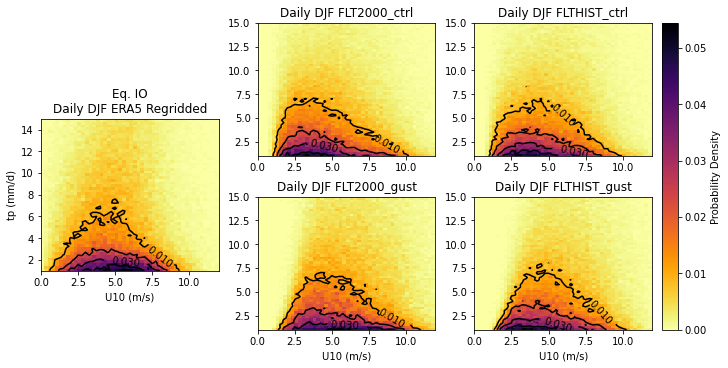

In [15]:
xVar = 'U10'
yVar = 'PRECT'

xMult = 1
yMult = 86400*1e3

xUnits = 'm/s'
yUnits = 'mm/d'

xVar_obs = 'U10'
yVar_obs = 'tp'

xMin = 0
xMax = 12

yMin = 1
yMax = 15

nBins_X = int((xMax-xMin)/0.25)
nBins_Y = int(np.round((yMax-yMin)/0.25))

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## Shouldn't need to change anything here; but create 1d arrays 
obs_xVar = np.asarray(pd.DataFrame((sel_era5[xVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]
obs_yVar = np.asarray(pd.DataFrame((sel_era5[yVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]

cam0_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam0_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam1_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam1_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam3_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=2).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam3_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=2).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam4_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=3).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam4_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=3).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]


## Make the plot
fig3 = plt.figure(constrained_layout=True, figsize=(10,5))
gs   = fig3.add_gridspec(4,4, width_ratios=[1,1,1,0.09], height_ratios=[0.75,1,1,0.75])

axs0 = fig3.add_subplot(gs[1:3, 0])
cplt = axs0.hist2d(obs_xVar, obs_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs0.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.01,0.05,0.01),inline=True, colors='k')
axs0.clabel(CS, CS.levels[::2], inline=True)

axs1 = fig3.add_subplot(gs[0:2, 1])
cplt = axs1.hist2d(cam0_xVar, cam0_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs1.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.01,0.05,0.01),inline=True, colors='k')
axs1.clabel(CS, CS.levels[::2], inline=True)

axs2 = fig3.add_subplot(gs[0:2, 2])
cplt = axs2.hist2d(cam3_xVar, cam3_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs2.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.01,0.05,0.01),inline=True, colors='k')
axs2.clabel(CS, CS.levels[::2], inline=True)

axs3 = fig3.add_subplot(gs[2::, 1])
cplt = axs3.hist2d(cam1_xVar, cam1_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs3.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.01,0.05,0.01),inline=True, colors='k')
axs3.clabel(CS, CS.levels[::2], inline=True)

axs4 = fig3.add_subplot(gs[2::, 2])
cplt = axs4.hist2d(cam4_xVar, cam4_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs4.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.01,0.05,0.01),inline=True, colors='k')
axs4.clabel(CS, CS.levels[::2], inline=True)

axsC = fig3.add_subplot(gs[0::, 3])
plt.colorbar(cplt[3], cax=axsC, label='Probability Density')

## Plot options 
axs0.set_xlabel(xVar_obs+' ('+xUnits+')')
axs0.set_ylabel(yVar_obs+' ('+yUnits+')')

axs3.set_xlabel(xVar+' ('+xUnits+')')
axs4.set_xlabel(xVar+' ('+xUnits+')')

axs0.set_xlim([xMin, xMax])
axs1.set_xlim([xMin, xMax])
axs2.set_xlim([xMin, xMax])
axs3.set_xlim([xMin, xMax])
axs4.set_xlim([xMin, xMax])

axs0.set_ylim([yMin, yMax])
axs1.set_ylim([yMin, yMax])
axs2.set_ylim([yMin, yMax])
axs3.set_ylim([yMin, yMax])
axs4.set_ylim([yMin, yMax])

axs0.set_title(regName+'\nDaily DJF ERA5 Regridded')
axs1.set_title('Daily DJF '+str(sel_h1.isel(case=0).case.values))
axs2.set_title('Daily DJF '+str(sel_h1.isel(case=2).case.values))
axs3.set_title('Daily DJF '+str(sel_h1.isel(case=1).case.values))
axs4.set_title('Daily DJF '+str(sel_h1.isel(case=3).case.values))


Text(0.5, 1.0, 'Daily DJF FLTHIST_gust')

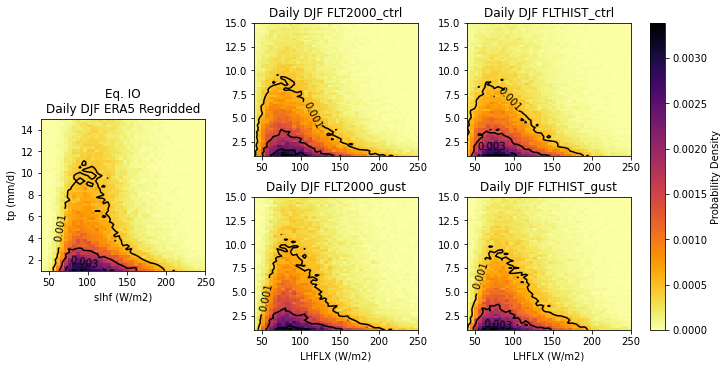

In [42]:
xVar = 'LHFLX'
yVar = 'PRECT'

xMult = 1
yMult = 86400*1e3

xUnits = 'W/m2'
yUnits = 'mm/d'

xVar_obs = 'slhf'
yVar_obs = 'tp'

xMin = 40
xMax = 250

yMin = 1
yMax = 15

nBins_Y = int((yMax-yMin)/0.25)
nBins_X = int(np.round((xMax-xMin)/5))

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## Shouldn't need to change anything here; but create 1d arrays 
obs_xVar = np.asarray(pd.DataFrame((sel_era5[xVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]
obs_yVar = np.asarray(pd.DataFrame((sel_era5[yVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]

cam0_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam0_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam1_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam1_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam3_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=2).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam3_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=2).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam4_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=3).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam4_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=3).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]


## Make the plot
fig3 = plt.figure(constrained_layout=True, figsize=(10,5))
gs   = fig3.add_gridspec(4,4, width_ratios=[1,1,1,0.09], height_ratios=[0.75,1,1,0.75])

axs0 = fig3.add_subplot(gs[1:3, 0])
cplt = axs0.hist2d(obs_xVar, obs_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs0.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0035,0.001), inline=True, colors='k')
axs0.clabel(CS, CS.levels[::2], inline=True)

axs1 = fig3.add_subplot(gs[0:2, 1])
cplt = axs1.hist2d(cam0_xVar, cam0_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs1.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0035,0.001), inline=True, colors='k')
axs1.clabel(CS, CS.levels[::2], inline=True)

axs2 = fig3.add_subplot(gs[0:2, 2])
cplt = axs2.hist2d(cam3_xVar, cam3_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs2.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0035,0.001), inline=True, colors='k')
axs2.clabel(CS, CS.levels[::2], inline=True)

axs3 = fig3.add_subplot(gs[2::, 1])
cplt = axs3.hist2d(cam1_xVar, cam1_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs3.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0035,0.001), inline=True, colors='k')
axs3.clabel(CS, CS.levels[::2], inline=True)

axs4 = fig3.add_subplot(gs[2::, 2])
cplt = axs4.hist2d(cam4_xVar, cam4_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs4.contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.0005,0.0035,0.001), inline=True, colors='k')
axs4.clabel(CS, CS.levels[::2], inline=True)

axsC = fig3.add_subplot(gs[0::, 3])
plt.colorbar(cplt[3], cax=axsC, label='Probability Density')

## Plot options 
axs0.set_xlabel(xVar_obs+' ('+xUnits+')')
axs0.set_ylabel(yVar_obs+' ('+yUnits+')')

axs3.set_xlabel(xVar+' ('+xUnits+')')
axs4.set_xlabel(xVar+' ('+xUnits+')')

axs0.set_xlim([xMin, xMax])
axs1.set_xlim([xMin, xMax])
axs2.set_xlim([xMin, xMax])
axs3.set_xlim([xMin, xMax])
axs4.set_xlim([xMin, xMax])

axs0.set_ylim([yMin, yMax])
axs1.set_ylim([yMin, yMax])
axs2.set_ylim([yMin, yMax])
axs3.set_ylim([yMin, yMax])
axs4.set_ylim([yMin, yMax])

axs0.set_title(regName+'\nDaily DJF ERA5 Regridded')
axs1.set_title('Daily DJF '+str(sel_h1.isel(case=0).case.values))
axs2.set_title('Daily DJF '+str(sel_h1.isel(case=2).case.values))
axs3.set_title('Daily DJF '+str(sel_h1.isel(case=1).case.values))
axs4.set_title('Daily DJF '+str(sel_h1.isel(case=3).case.values))


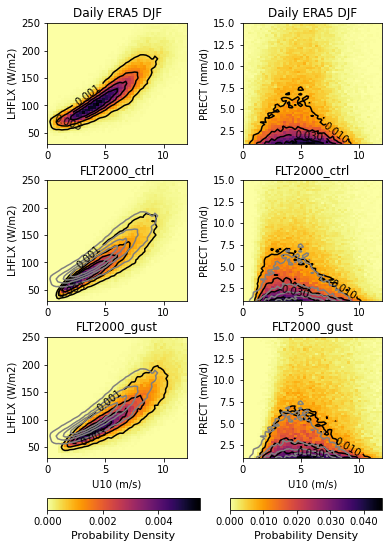

In [31]:
fig,axs = plt.subplots(3,2, figsize=(6,8))
axs     = axs.ravel()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Plot first column: U10 vs LHFLX
xVar = 'U10'
yVar = 'LHFLX'

xMult = 1
yMult = 1

xUnits = 'm/s'
yUnits = 'W/m2'

xVar_obs = 'U10'
yVar_obs = 'slhf'

xMin = 0
xMax = 12

yMin = 30
yMax = 250

nBins_X = int((xMax-xMin)/0.25)
nBins_Y = int(np.round((yMax-yMin)/5))

## Shouldn't need to change anything here; but create 1d arrays 
obs_xVar = np.asarray(pd.DataFrame((sel_era5[xVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]
obs_yVar = np.asarray(pd.DataFrame((sel_era5[yVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]

cam0_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam0_yVar = np.asarray(pd.DataFrame((sel_h1[yVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam1_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam1_yVar = np.asarray(pd.DataFrame((sel_h1[yVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cplt_obs1 = axs[0].hist2d(obs_xVar, obs_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs[0].contour(cplt_obs1[1][0:-1], cplt_obs1[2][0:-1], 
                      np.transpose(cplt_obs1[0]), np.arange(0.0005,0.0045,0.001), inline=True, colors='k')
axs[0].clabel(CS, CS.levels[::2], inline=True)

cplt_ctrl = axs[2].hist2d(cam0_xVar, cam0_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs[2].contour(cplt_ctrl[1][0:-1], cplt_ctrl[2][0:-1], 
                    np.transpose(cplt_ctrl[0]), np.arange(0.0005,0.0045,0.001), inline=True, colors='k')
axs[2].clabel(CS, CS.levels[::2], inline=True)
CS2   = axs[2].contour(cplt_obs1[1][0:-1], cplt_obs1[2][0:-1], 
                      np.transpose(cplt_obs1[0]), np.arange(0.0005,0.0045,0.001), inline=True, colors='grey')

cplt_gust = axs[4].hist2d(cam1_xVar, cam1_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.09, ax_position.width, 0.02])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax,format='%.3f')
cbar.set_label('Probability Density',fontsize=11)
# Add contours
CS   = axs[4].contour(cplt_gust[1][0:-1], cplt_gust[2][0:-1], 
                    np.transpose(cplt_gust[0]), np.arange(0.0005,0.0045,0.001), inline=True, colors='k')
axs[4].clabel(CS, CS.levels[::2], inline=True)
CS2   = axs[4].contour(cplt_obs1[1][0:-1], cplt_obs1[2][0:-1], 
                      np.transpose(cplt_obs1[0]), np.arange(0.0005,0.0045,0.001), inline=True, colors='grey')


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Plot second column: U10 vs PRECT
xVar = 'U10'
yVar = 'PRECT'

xMult = 1
yMult = 86400*1e3

xUnits = 'm/s'
yUnits = 'mm/d'

xVar_obs = 'U10'
yVar_obs = 'tp'

xMin = 0
xMax = 12

yMin = 1
yMax = 15

nBins_X = int((xMax-xMin)/0.25)
nBins_Y = int(np.round((yMax-yMin)/0.25))

obs_xVar = np.asarray(pd.DataFrame((sel_era5[xVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]
obs_yVar = np.asarray(pd.DataFrame((sel_era5[yVar_obs].values*reg_ocnMask_ERA5).reshape(numEl_ERA5,1)).dropna().values)[:,0]

cam0_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam0_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=0).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cam1_xVar = np.asarray(pd.DataFrame((sel_h1[xVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]
cam1_yVar = np.asarray(pd.DataFrame((yMult*sel_h1[yVar].isel(case=1).values*reg_ocnMask_CAM).reshape(numEl_CAM,1)).dropna().values)[:,0]

cplt_obs = axs[1].hist2d(obs_xVar, obs_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs[1].contour(cplt_obs[1][0:-1], cplt_obs[2][0:-1], 
                    np.transpose(cplt_obs[0]), np.arange(0.01,0.05,0.01),inline=True, colors='k')
axs[1].clabel(CS, CS.levels[::2], inline=True)

cplt = axs[3].hist2d(cam0_xVar, cam0_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
CS   = axs[3].contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.01,0.05,0.01),inline=True, colors='k')
axs[3].clabel(CS, CS.levels[::2], inline=True)
CS2   = axs[3].contour(cplt_obs[1][0:-1], cplt_obs[2][0:-1], 
                    np.transpose(cplt_obs[0]), np.arange(0.01,0.05,0.01),inline=True, colors='gray')

cplt = axs[5].hist2d(cam1_xVar, cam1_yVar, bins=(nBins_X, nBins_Y), range=[[xMin,xMax], [yMin,yMax]], density=True, cmap=plt.cm.inferno_r)
# Add colorbar
ax_position = axs[5].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.09, ax_position.width, 0.02])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax,format='%.3f')
cbar.set_label('Probability Density',fontsize=11)
# Add contours
CS   = axs[5].contour(cplt[1][0:-1], cplt[2][0:-1], 
                    np.transpose(cplt[0]), np.arange(0.01,0.05,0.01),inline=True, colors='k')
axs[5].clabel(CS, CS.levels[::2], inline=True)
CS2   = axs[5].contour(cplt_obs[1][0:-1], cplt_obs[2][0:-1], 
                    np.transpose(cplt_obs[0]), np.arange(0.01,0.05,0.01),inline=True, colors='gray')
## Other plot options 

axs[0].set_title('Daily ERA5 DJF')
axs[1].set_title('Daily ERA5 DJF')

axs[2].set_title(sel_h1.isel(case=0).case.values)
axs[3].set_title(sel_h1.isel(case=0).case.values)

axs[4].set_title(sel_h1.isel(case=1).case.values)
axs[5].set_title(sel_h1.isel(case=1).case.values)

axs[4].set_xlabel('U10 (m/s)')
axs[5].set_xlabel('U10 (m/s)')

axs[0].set_ylabel('LHFLX (W/m2)')
axs[2].set_ylabel('LHFLX (W/m2)')
axs[4].set_ylabel('LHFLX (W/m2)')

axs[1].set_ylabel('PRECT (mm/d)')
axs[3].set_ylabel('PRECT (mm/d)')
axs[5].set_ylabel('PRECT (mm/d)')

fig.subplots_adjust(hspace=0.3, wspace=0.4)


Text(0, 0.5, 'LHFLX (W/m2)')

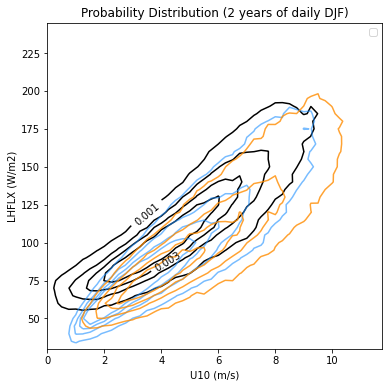

In [32]:
fig,axs = plt.subplots(1,1,figsize=(6,6))

CS   = axs.contour(cplt_obs1[1][0:-1], cplt_obs1[2][0:-1], 
                      np.transpose(cplt_obs1[0]), np.arange(0.0005,0.0045,0.001), inline=True, 
                      colors='k')
axs.clabel(CS, CS.levels[::2], inline=True)

CS   = axs.contour(cplt_ctrl[1][0:-1], cplt_ctrl[2][0:-1], 
                      np.transpose(cplt_ctrl[0]), np.arange(0.0005,0.0045,0.001), inline=True, 
                      colors='dodgerblue', alpha=0.6)
# axs.clabel(CS, CS.levels[::2], inline=True)

CS   = axs.contour(cplt_gust[1][0:-1], cplt_gust[2][0:-1], 
                      np.transpose(cplt_gust[0]), np.arange(0.0005,0.0045,0.001), inline=True, 
                      colors='darkorange', alpha=0.8)
# axs.clabel(CS, CS.levels[::2], inline=True)

axs.legend(['ERA5','CTRL','GUST'])
axs.set_title('Probability Distribution (2 years of daily DJF)')
axs.set_xlabel('U10 (m/s)')
axs.set_ylabel('LHFLX (W/m2)')


In [40]:
sel_h1_allYears = sel_h1_allYears.where(sel_h1_allYears.PRECC>0.25)

In [41]:
xVar = 'U10'
yVar = 'LHFLX'

corrCoefs_CAM = xr.corr(sel_h1_allYears[xVar], sel_h1_allYears[yVar], dim='time').load()

xVarObs = 'U10'
yVarObs = 'slhf'

corrCoefs_ERA5 = xr.corr(sel_era5[xVarObs], sel_era5[yVarObs], dim='time')


ValueError: 'bboxes' cannot be empty

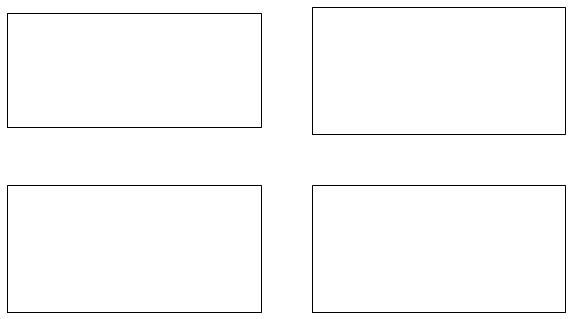

In [42]:
# U10 and LHFLX
cmax = 0.92
cmin = 0.5

# # U10 and PRECT
# cmax = 0.5
# cmin = -0.1

# # LHFLX and PRECT
# cmax = 0.5
# cmin = -0.4 

cstep = (cmax-cmin)/26
levsSel = np.arange(cmin,cmax+cstep,cstep)   # LHFLX and PRECT

cmapSel = 'viridis'

fig,axs = plt.subplots(2,2, figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs = axs.ravel()

cplt = axs[0].contourf(corrCoefs_CAM.lon.values, corrCoefs_CAM.lat.values, 
                     corrCoefs_CAM.isel(case=0).values*reg_ocnMask, levsSel,
                     cmap=cmapSel, extend='both',transform=ccrs.PlateCarree())

cplt = axs[1].contourf(corrCoefs_CAM.lon.values, corrCoefs_CAM.lat.values, 
                     corrCoefs_CAM.isel(case=2).values*reg_ocnMask, levsSel,
                     cmap=cmapSel, extend='both',transform=ccrs.PlateCarree())

cplt = axs[2].contourf(corrCoefs_CAM.lon.values, corrCoefs_CAM.lat.values, 
                     corrCoefs_CAM.isel(case=1).values*reg_ocnMask, levsSel,
                     cmap=cmapSel, extend='both',transform=ccrs.PlateCarree())

cplt = axs[3].contourf(corrCoefs_CAM.lon.values, corrCoefs_CAM.lat.values, 
                     corrCoefs_CAM.isel(case=3).values*reg_ocnMask, levsSel,
                     cmap=cmapSel, extend='both',transform=ccrs.PlateCarree())
# Add colorbar
ax_position = axs[3].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.02])
cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax,format='%.2f')
cbar.set_label('Corr Coef',fontsize=11)

axs[0].set_title('Daily DJF CorrCoef '+xVar+' vs. '+yVar+'\n'+str(sel_h1.isel(case=0).case.values))
axs[1].set_title(str(sel_h1.isel(case=2).case.values))
axs[2].set_title(str(sel_h1.isel(case=1).case.values))
axs[3].set_title(str(sel_h1.isel(case=3).case.values))

axs[0].coastlines()
axs[1].coastlines()
axs[2].coastlines()
axs[3].coastlines()



In [182]:

# levsSel = np.arange(0.5,1.0,0.025)
# cmapSel = 'cool'

# ## Make the plot
# fig3 = plt.figure(constrained_layout=True, figsize=(10,5))
# gs   = fig3.add_gridspec(4,4, width_ratios=[1,1,1,0.09], height_ratios=[0.75,1,1,0.75])

# axs0 = fig3.add_subplot(gs[1:3, 0], projection=ccrs.PlateCarree(central_longitude=180))
# cplt = axs0.contourf(corrCoefs_ERA5.lon.values, corrCoefs_ERA5.lat.values, 
#                      corrCoefs_ERA5.values*reg_ocnMask, levsSel,
#                      cmap=cmapSel, extend='both',transform=ccrs.PlateCarree())

# axs1 = fig3.add_subplot(gs[0:2, 1], projection=ccrs.PlateCarree(central_longitude=180))
# cplt = axs1.contourf(corrCoefs_CAM.lon.values, corrCoefs_CAM.lat.values, 
#                      corrCoefs_CAM.isel(case=0).values*reg_ocnMask, levsSel,
#                      cmap=cmapSel, extend='both',transform=ccrs.PlateCarree())

# axs2 = fig3.add_subplot(gs[0:2, 2], projection=ccrs.PlateCarree(central_longitude=180))
# cplt = axs2.contourf(corrCoefs_CAM.lon.values, corrCoefs_CAM.lat.values, 
#                      corrCoefs_CAM.isel(case=2).values*reg_ocnMask, levsSel,
#                      cmap=cmapSel, extend='both',transform=ccrs.PlateCarree())

# axs3 = fig3.add_subplot(gs[2::, 1], projection=ccrs.PlateCarree(central_longitude=180))
# cplt = axs3.contourf(corrCoefs_CAM.lon.values, corrCoefs_CAM.lat.values, 
#                      corrCoefs_CAM.isel(case=1).values*reg_ocnMask, levsSel,
#                      cmap=cmapSel, extend='both',transform=ccrs.PlateCarree())

# axs4 = fig3.add_subplot(gs[2::, 2], projection=ccrs.PlateCarree(central_longitude=180))
# cplt = axs4.contourf(corrCoefs_CAM.lon.values, corrCoefs_CAM.lat.values, 
#                      corrCoefs_CAM.isel(case=3).values*reg_ocnMask, levsSel,
#                      cmap=cmapSel, extend='both',transform=ccrs.PlateCarree())

# axsC = fig3.add_subplot(gs[0::, 3])
# plt.colorbar(cplt, cax=axsC, label='Correlation Coefficient')

# # ## Plot options 
# axs0.set_title(regName+'\nDaily DJF ERA5 Regridded')
# axs1.set_title('Daily DJF '+str(sel_h1.isel(case=0).case.values))
# axs2.set_title('Daily DJF '+str(sel_h1.isel(case=2).case.values))
# axs3.set_title('Daily DJF '+str(sel_h1.isel(case=1).case.values))
# axs4.set_title('Daily DJF '+str(sel_h1.isel(case=3).case.values))



## Older code

Text(0.5, 1.0, 'DJF 2013-2014 LHFLX (ERA-5 Daily)')

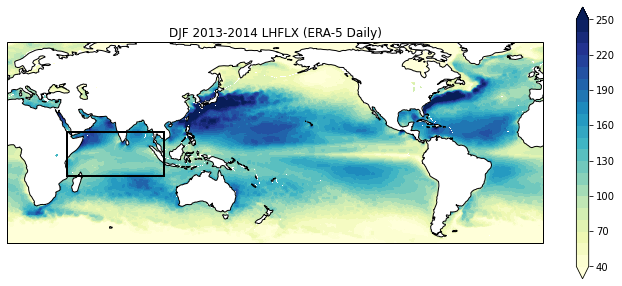

In [12]:
fig,axs = plt.subplots(1,1, figsize=(12,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
c = axs.contourf(era5_daily.longitude.values, era5_daily.latitude.values, 
                 ocnMask*era5_daily.slhf.mean(dim='time').values, np.arange(40,260,10), 
                 cmap ='YlGnBu', extend='both',
                 transform = ccrs.PlateCarree())
plt.colorbar(c)
axs.coastlines()
axs.set_extent([np.nanmin(era5_daily.longitude.values),
                np.nanmax(era5_daily.longitude.values),
                -60,75], crs=ccrs.PlateCarree())


axs.add_patch(patches.Rectangle(xy=[40, -15], width=65, height=30,
                                facecolor='none',
                                edgecolor='k',
                                linewidth=2,
                                transform=ccrs.PlateCarree())
             )

axs.set_title('DJF 2013-2014 LHFLX (ERA-5 Daily)')

Text(0.5, 1.0, 'DJF 2013-2014 Precip (ERA-5 Daily)')

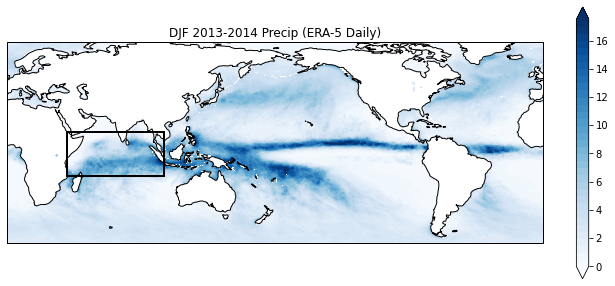

In [11]:
fig,axs = plt.subplots(1,1, figsize=(12,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

c = axs.contourf(era5_daily.longitude.values, era5_daily.latitude.values, 
                 ocnMask*era5_daily.tp.mean(dim='time').values, 
                 np.arange(0,18,0.5), 
                 cmap ='Blues', extend='both',
                 transform = ccrs.PlateCarree())
plt.colorbar(c)
axs.coastlines()
axs.set_extent([np.nanmin(era5_daily.longitude.values),
                np.nanmax(era5_daily.longitude.values),
                -60,75], crs=ccrs.PlateCarree())

axs.add_patch(patches.Rectangle(xy=[40, -15], width=65, height=30,
                                facecolor='none',
                                edgecolor='k',
                                linewidth=2,
                                transform=ccrs.PlateCarree())
             )

    
axs.set_title('DJF 2013-2014 Precip (ERA-5 Daily)')

In [13]:
iselLat = np.where((era5_daily.latitude.values>=-15) & (era5_daily.latitude.values<=15))[0]
iselLon = np.where((era5_daily.longitude.values>=40) & (era5_daily.longitude.values<=105))[0]
iselTimes = np.where((era5_daily['time.month'].values==12) | (era5_daily['time.month'].values<=2))[0]

selDS = era5_daily.isel(latitude=iselLat, longitude=iselLon, time=iselTimes)

## Get an ocn mask the exact same size 
selMask  = np.full([len(selDS.time.values), len(selDS.latitude.values), len(selDS.longitude.values)], np.nan)
for iTime in range(len(selDS.time.values)):
    temp = ocnMask[iselLat,:]
    selMask[iTime,:,:] = temp[:, iselLon]


In [14]:

maskSLHF = selDS['slhf'] * selMask
maskTP   = selDS['tp']   * selMask
maskU10  = selDS['u10n'] * selMask
maskV10  = selDS['v10n'] * selMask
windMag  = np.sqrt((maskU10**2)+ (maskV10**2))

numEl = len(selDS.time.values)*len(selDS.latitude.values)*len(selDS.longitude.values)

DF_mask = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'slhf': np.squeeze(maskSLHF.values.reshape(numEl,1))}),
         pd.DataFrame.from_dict({'tp': np.squeeze(maskTP.values.reshape(numEl,1))}),
         pd.DataFrame.from_dict({'u10n': np.squeeze(maskU10.values.reshape(numEl,1))}),
         pd.DataFrame.from_dict({'windMag': np.squeeze(windMag.values.reshape(numEl,1))}),
         ])

DF_mask['slhf'] = DF_mask['slhf'].dropna()
DF_mask['tp']   = DF_mask['tp'].dropna()
DF_mask['u10n'] = DF_mask['u10n'].dropna()
DF_mask['windMag'] = DF_mask['windMag'].dropna()


(0.001, 1000.0)

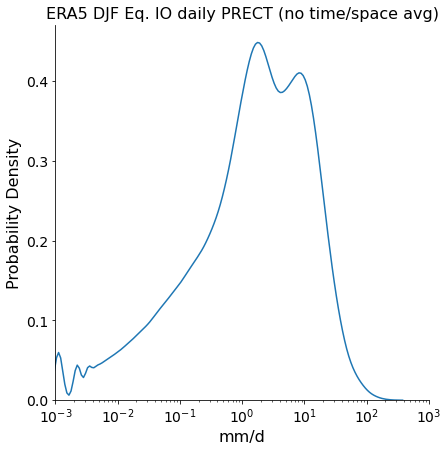

In [19]:
# Make plot 
g = sns.displot(DF_mask, x='tp', kind='kde', height=6, cut=0, 
                log_scale=True, 
                 palette=['dodgerblue'])

g.ax.set_xlabel('mm/d',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)
g.ax.set_title('ERA5 DJF Eq. IO daily PRECT (no time/space avg)',fontsize=16)
g.ax.set_xlim([1e-3,1e3])



In [15]:
## Filter to only look at strong-ish rain rates? 
iSelRain = np.where( (DF_mask['tp'].dropna()>=1.0) & (DF_mask['tp'].dropna()<=100))[0]


Text(0, 0.5, 'tp')

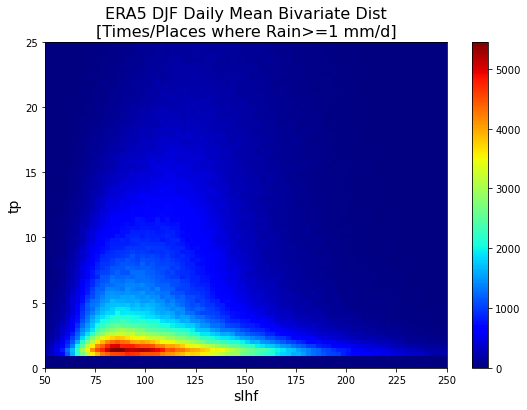

In [16]:
xvar = 'slhf'
yvar = 'tp'

fig,axs = plt.subplots(1,1,figsize=(9,6))

cplt = axs.hist2d(DF_mask[xvar].dropna().values[iSelRain], DF_mask[yvar].dropna().values[iSelRain], 
                bins=(80, 80), range=[[50,250], [0,25]], cmap=plt.cm.jet)
plt.colorbar(cplt[3])


axs.set_title('ERA5 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs.set_xlabel(xvar,fontsize=14)
axs.set_ylabel(yvar, fontsize=14)



Text(0, 0.5, 'slhf')

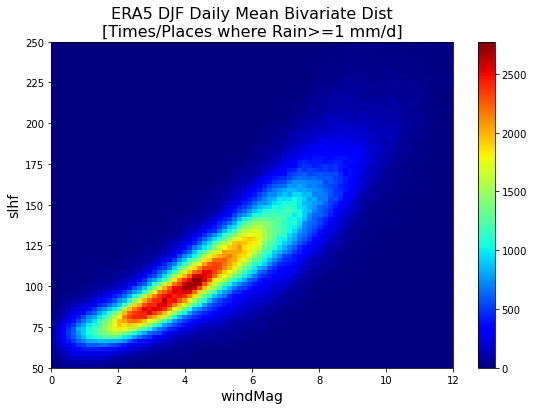

In [223]:
xvar = 'windMag'
yvar = 'slhf'

fig,axs = plt.subplots(1,1,figsize=(9,6))

cplt = axs.hist2d(DF_mask[xvar].dropna().values[iSelRain], DF_mask[yvar].dropna().values[iSelRain], 
                bins=(80, 80), range=[[0,12], [50,250]],cmap=plt.cm.jet)
plt.colorbar(cplt[3])


axs.set_title('ERA5 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs.set_xlabel(xvar,fontsize=14)
axs.set_ylabel(yvar, fontsize=14)



Text(0, 0.5, 'tp')

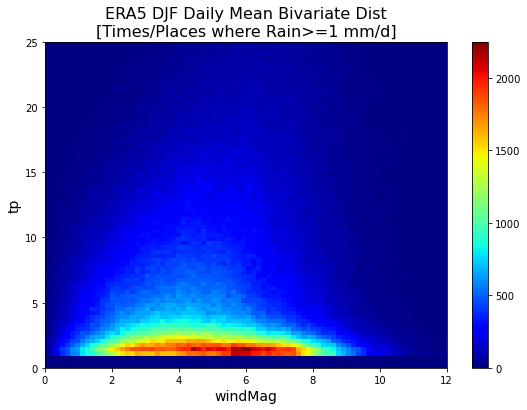

In [225]:
xvar = 'windMag'
yvar = 'tp'

fig,axs = plt.subplots(1,1,figsize=(9,6))

cplt = axs.hist2d(DF_mask[xvar].dropna().values[iSelRain], DF_mask[yvar].dropna().values[iSelRain], 
                bins=(80, 80), range=[[0,12], [0,25]],cmap=plt.cm.jet)
plt.colorbar(cplt[3])


axs.set_title('ERA5 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs.set_xlabel(xvar,fontsize=14)
axs.set_ylabel(yvar, fontsize=14)



### Make scatters for CAM data

In [23]:
iselLat = np.where((all_h1.lat.values>=-15) & (all_h1.lat.values<=15))[0]
iselLon = np.where((all_h1.lon.values>=40) & (all_h1.lon.values<=105))[0]
iselTimes = np.where((all_h1['time.month'].values==12) | (all_h1['time.month'].values<=2))[0]

sel_h1= all_h1.isel(lat=iselLat, lon=iselLon, time=iselTimes)

## Get an ocn mask the exact same size 
selMask  = np.full([len(sel_h1.time.values), 
                    len(sel_h1.lat.values), 
                    len(sel_h1.lon.values)], np.nan)
for iTime in range(len(sel_h1.time.values)):
    temp = ocnMask_cam[0,iselLat,:]
    selMask[iTime,:,:] = temp[:, iselLon]


In [24]:
## Regrid ERA5 data to match?
iselLat = np.where((era5_daily.latitude.values>=-15) & (era5_daily.latitude.values<=15))[0]
iselLon = np.where((era5_daily.longitude.values>=40) & (era5_daily.longitude.values<=105))[0]
iselTimes = np.where((era5_daily['time.month'].values==12) | (era5_daily['time.month'].values<=2))[0]

selDS = era5_daily.isel(latitude=iselLat, longitude=iselLon, time=iselTimes)

## Convert longitude to be 0 to 360, not -180 to 180. 
selDS.coords['longitude'] = (selDS.coords['longitude'] + 360) % 360 
selDS = selDS.sortby(selDS.longitude)

## Make sure dimension name/order are in agreement with CAM 
selDS = selDS.reindex(latitude=selDS.latitude[::-1])
selDS = selDS.rename_dims(dims_dict={'latitude':'lat', 'longitude':'lon'})
selDS = selDS.rename(name_dict={'latitude':'lat', 'longitude':'lon'})

regrid_era5 = regrid_data(selDS, sel_h1, method=1)



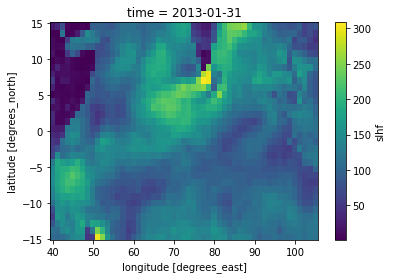

In [40]:
regrid_era5.isel(time=30).slhf.plot()

In [66]:

maskSLHF = regrid_era5['slhf'] * selMask[0:len(regrid_era5.time.values),:,:]
maskTP   = regrid_era5['tp']   * selMask[0:len(regrid_era5.time.values),:,:]
maskU10  = regrid_era5['u10n'] * selMask[0:len(regrid_era5.time.values),:,:]
maskV10  = regrid_era5['v10n'] * selMask[0:len(regrid_era5.time.values),:,:]
windMag  = np.sqrt((maskU10**2)+ (maskV10**2))

numEl = len(regrid_era5.time.values)*len(regrid_era5.lat.values)*len(regrid_era5.lon.values)

DF_mask = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'slhf': np.squeeze(maskSLHF.values.reshape(numEl,1))}),
         pd.DataFrame.from_dict({'tp': np.squeeze(maskTP.values.reshape(numEl,1))}),
         pd.DataFrame.from_dict({'u10n': np.squeeze(maskU10.values.reshape(numEl,1))}),
         pd.DataFrame.from_dict({'windMag': np.squeeze(windMag.values.reshape(numEl,1))}),
         ])

DF_mask['slhf'] = DF_mask['slhf'].dropna()
DF_mask['tp']   = DF_mask['tp'].dropna()
DF_mask['u10n'] = DF_mask['u10n'].dropna()
DF_mask['windMag'] = DF_mask['windMag'].dropna()


In [45]:
np.shape(selMask[0:len(regrid_era5.time.values),:,:])

(180, 32, 53)

In [70]:
sel_h1_2yrs = sel_h1.isel(time=np.arange(0,181))


maskSLHF_gust = sel_h1_2yrs['LHFLX'].isel(case=1) * selMask[0:181,:,:]
maskTP_gust   = sel_h1_2yrs['PRECT'].isel(case=1) * selMask[0:181,:,:] * 86400*1e3
windMag_gust  = sel_h1_2yrs['U10'].isel(case=1)   * selMask[0:181,:,:]

maskSLHF_ctrl = sel_h1_2yrs['LHFLX'].isel(case=0) * selMask[0:181,:,:]
maskTP_ctrl   = sel_h1_2yrs['PRECT'].isel(case=0)  * selMask[0:181,:,:] * 86400*1e3
windMag_ctrl  = sel_h1_2yrs['U10'].isel(case=0)    * selMask[0:181,:,:]

numEl = len(sel_h1_2yrs.time.values)*len(sel_h1_2yrs.lat.values)*len(sel_h1_2yrs.lon.values)


DF_ctrl = pd.concat(axis=0, ignore_index=True, objs=[
          pd.DataFrame.from_dict({'slhf':    np.squeeze(maskSLHF_ctrl.values.reshape(numEl,1))}),
          pd.DataFrame.from_dict({'tp':      np.squeeze(maskTP_ctrl.values.reshape(numEl,1))}),
          pd.DataFrame.from_dict({'windMag': np.squeeze(windMag_ctrl.values.reshape(numEl,1))}),
          ])
DF_ctrl['slhf']    = DF_ctrl['slhf'].dropna()
DF_ctrl['tp']      = DF_ctrl['tp'].dropna()
DF_ctrl['windMag'] = DF_ctrl['windMag'].dropna()


DF_gust = pd.concat(axis=0, ignore_index=True, objs=[
          pd.DataFrame.from_dict({'slhf':    np.squeeze(maskSLHF_gust.values.reshape(numEl,1))}),
          pd.DataFrame.from_dict({'tp':      np.squeeze(maskTP_gust.values.reshape(numEl,1))}),
          pd.DataFrame.from_dict({'windMag': np.squeeze(windMag_gust.values.reshape(numEl,1))}),
          ])
DF_gust['slhf']    = DF_gust['slhf'].dropna()
DF_gust['tp']      = DF_gust['tp'].dropna()
DF_gust['windMag'] = DF_gust['windMag'].dropna()



In [71]:
## Filter to only look at strong-ish rain rates? 
iSelRain_gust = np.where( (DF_gust['tp'].dropna()>=1.0) & (DF_gust['tp'].dropna()<=100))[0]
iSelRain_ctrl = np.where( (DF_ctrl['tp'].dropna()>=1.0) & (DF_ctrl['tp'].dropna()<=100))[0]

iSelRain = np.where( (DF_mask['tp'].dropna()>=1.0) & (DF_mask['tp'].dropna()<=100))[0]


Text(0, 0.5, 'tp')

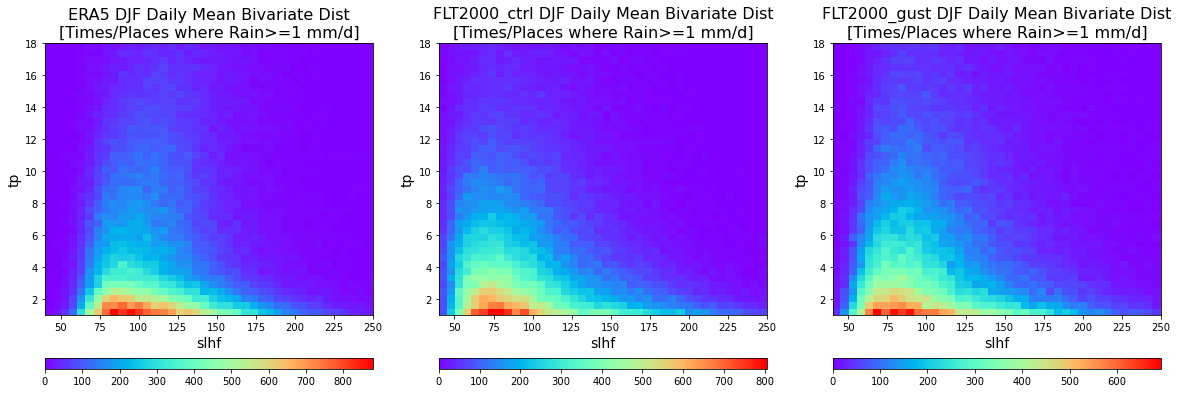

In [73]:
xvar = 'slhf'
yvar = 'tp'

fig,axs = plt.subplots(1,3,figsize=(20,5))
axs = axs.ravel()

cplt = axs[0].hist2d(DF_mask[xvar].dropna().values[iSelRain], DF_mask[yvar].dropna().values[iSelRain], 
                bins=(40, 40), range=[[40,250], [1,18]], cmap='rainbow')
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.03])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax)

cplt = axs[1].hist2d(DF_ctrl[xvar].dropna().values[iSelRain_ctrl], DF_ctrl[yvar].dropna().values[iSelRain_ctrl], 
                bins=(40, 40), range=[[40,250], [1,18]], cmap='rainbow')
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.03])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax)

cplt = axs[2].hist2d(DF_gust[xvar].dropna().values[iSelRain_gust], DF_gust[yvar].dropna().values[iSelRain_gust], 
                bins=(40, 40), range=[[40,250], [1,18]], cmap='rainbow')
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.03])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax)


axs[0].set_title('ERA5 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs[0].set_xlabel(xvar,fontsize=14)
axs[0].set_ylabel(yvar, fontsize=14)


axs[1].set_title(str(maskSLHF_ctrl.case.values)+' DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs[1].set_xlabel(xvar,fontsize=14)
axs[1].set_ylabel(yvar, fontsize=14)


axs[2].set_title(str(maskSLHF_gust.case.values)+' DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs[2].set_xlabel(xvar,fontsize=14)
axs[2].set_ylabel(yvar, fontsize=14)



Text(0, 0.5, 'slhf')

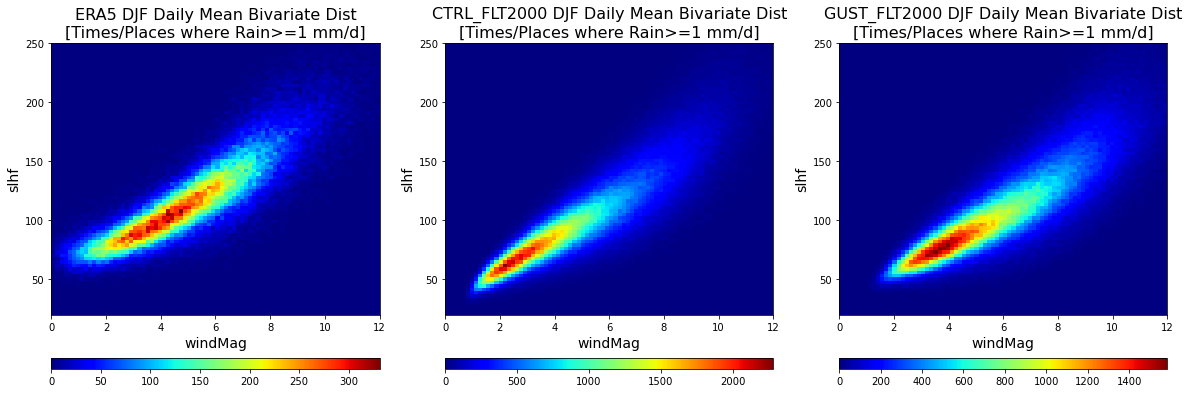

In [27]:
xvar = 'windMag'
yvar = 'slhf'

fig,axs = plt.subplots(1,3,figsize=(20,5))
axs = axs.ravel()

cplt = axs[0].hist2d(DF_mask[xvar].dropna().values[iSelRain], DF_mask[yvar].dropna().values[iSelRain], 
                bins=(80, 80), range=[[0,12], [20,250]], cmap=plt.cm.jet)
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.03])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax)

cplt = axs[1].hist2d(DF_ctrl[xvar].dropna().values[iSelRain_ctrl], DF_ctrl[yvar].dropna().values[iSelRain_ctrl], 
                bins=(80, 80), range=[[0,12], [20,250]], cmap=plt.cm.jet)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.03])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax)

cplt = axs[2].hist2d(DF_gust[xvar].dropna().values[iSelRain_gust], DF_gust[yvar].dropna().values[iSelRain_gust], 
                bins=(80, 80), range=[[0,12], [20,250]], cmap=plt.cm.jet)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.03])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax)


axs[0].set_title('ERA5 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs[0].set_xlabel(xvar,fontsize=14)
axs[0].set_ylabel(yvar, fontsize=14)


axs[1].set_title('CTRL_FLT2000 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs[1].set_xlabel(xvar,fontsize=14)
axs[1].set_ylabel(yvar, fontsize=14)


axs[2].set_title('GUST_FLT2000 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs[2].set_xlabel(xvar,fontsize=14)
axs[2].set_ylabel(yvar, fontsize=14)



Text(0, 0.5, 'tp')

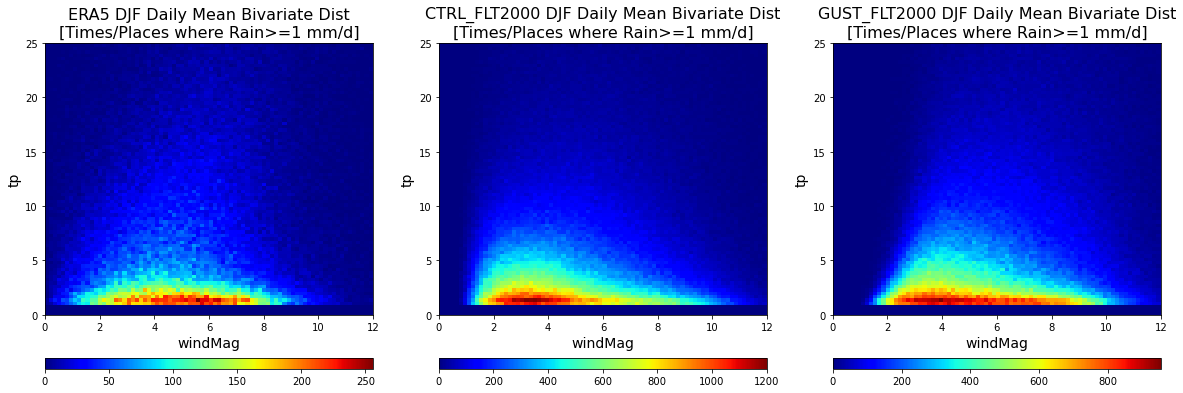

In [27]:
xvar = 'windMag'
yvar = 'tp'

fig,axs = plt.subplots(1,3,figsize=(20,5))
axs = axs.ravel()

nbinsX = 80
nbinsY = 80

cplt = axs[0].hist2d(DF_mask[xvar].dropna().values[iSelRain], DF_mask[yvar].dropna().values[iSelRain], 
#                 bins=(80, 40), range=[[0,12], [0,25]], cmap=plt.cm.jet)
                bins=(nbinsX, nbinsY), range=[[0,12], [0,25]], cmap=plt.cm.jet)
# Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.03])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax)

cplt = axs[1].hist2d(DF_ctrl[xvar].dropna().values[iSelRain_ctrl], DF_ctrl[yvar].dropna().values[iSelRain_ctrl], 
                bins=(nbinsX, nbinsY), range=[[0,12], [0,25]], cmap=plt.cm.jet)
# Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.03])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax)

cplt = axs[2].hist2d(DF_gust[xvar].dropna().values[iSelRain_gust], DF_gust[yvar].dropna().values[iSelRain_gust], 
                bins=(nbinsX, nbinsY), range=[[0,12], [0,25]], cmap=plt.cm.jet)
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.15, ax_position.width, 0.03])
cbar        = plt.colorbar(cplt[3], orientation='horizontal',cax=cbar_ax)


axs[0].set_title('ERA5 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs[0].set_xlabel(xvar,fontsize=14)
axs[0].set_ylabel(yvar, fontsize=14)


axs[1].set_title('CTRL_FLT2000 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs[1].set_xlabel(xvar,fontsize=14)
axs[1].set_ylabel(yvar, fontsize=14)


axs[2].set_title('GUST_FLT2000 DJF Daily Mean Bivariate Dist\n[Times/Places where Rain>=1 mm/d]',fontsize=16)
axs[2].set_xlabel(xvar,fontsize=14)
axs[2].set_ylabel(yvar, fontsize=14)

